# Random Forest vs Boosted Trees

In [1]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor 
import numpy as np
import random

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import warnings
import random
warnings.simplefilter(action='ignore', category=Warning)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Random Forest

## Classification

In [2]:
class RandomForestCls:
    def __init__(self,n_trees = 100,max_depth = 10,min_samples_split = 2,fraction_samples=1,bootstrap=False):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.bootstrapping = bootstrap
        self.min_samples_split = min_samples_split
        self.feature_select_trees = []
        self.fraction_samples = fraction_samples

        self.trees = []

    def _bootstrap(self,X_train,y_train,n_features):
            
            if self.bootstrapping:
                num_samples = X_train.shape[0]
                num_resampled_samples = int(num_samples*self.fraction_samples)

                # Generate random indices with replacement
                resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=True)

                # Create resampled datasets based on the selected indices
                feature_selection = random.sample(range(X_train.shape[1]),n_features)
                self.feature_select_trees.append(feature_selection)
                X_resampled = X_train[resampled_indices]
                X_resampled = X_resampled[:,feature_selection]

                y_resampled = y_train[resampled_indices]
            else:
                num_samples = X_train.shape[0]
                num_resampled_samples = int(num_samples*self.fraction_samples)

                # Generate random indices with replacement
                resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=False)

                # Create resampled datasets based on the selected indices
                feature_selection = random.sample(range(X_train.shape[1]),n_features)
                self.feature_select_trees.append(feature_selection)
                X_resampled = X_train[resampled_indices]
                X_resampled = X_resampled[:,feature_selection]

                y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled
    
    def fit(self,X,y):
        self.trees = []
        for _ in range(self.n_trees):
            model = DecisionTreeClassifier(max_depth=self.max_depth,min_samples_split = self.min_samples_split)

            X_sample,y_sample = self._bootstrap(X,y,n_features=random.randint(2,X.shape[1]))
            model.fit(X_sample,y_sample)
            self.trees.append(model)
    
    def return_indices_of_features_trees(self):
         return self.feature_select_trees

    def predict(self,X):
        results = []
        idx_trees = self.return_indices_of_features_trees()

        for idx,tree in enumerate(self.trees):
            output = tree.predict(X[:,idx_trees[idx]])
            results.append(output)
        results = np.stack(results)
        results = np.sum(results,axis=0)//(len(idx_trees)//2)
        return results

### Data Processing

In [7]:
# Load the classification dataset
classification_df = pd.read_csv('WineQT.csv')

# Remove the 'Id' column from features
classification_df = classification_df.drop(columns=['Id'])

# Define the feature columns and label column
classification_features = classification_df.drop(columns=['quality'])

"""
Standardize the data
"""

classification_features = np.array(classification_features)

classification_features = (classification_features - np.mean(classification_features,axis=0)) / np.std(classification_features,axis=0)

classification_labels = np.array(classification_df['quality'])

"""
Binary classification    
"""
# for classes 3,4,5
classification_labels[classification_labels<=5] = 0

# for classes 6,7,8
classification_labels[classification_labels>=6] = 1
"""
End
"""

# Split the classification dataset into train, validation, and test sets
classification_train_features, classification_temp_features, classification_train_labels, classification_temp_labels = train_test_split(
    classification_features, classification_labels, test_size=0.30, random_state=42)

classification_val_features, classification_test_features, classification_val_labels, classification_test_labels  = train_test_split(
    classification_temp_features, classification_temp_labels, test_size=0.50, random_state=42)

In [16]:
X_train_classification,y_train_classification = classification_train_features,classification_train_labels

In [24]:
X_val_classification,y_val_classification = classification_val_features,classification_val_labels

In [17]:
X_test_classification,y_test_classification = classification_test_features,classification_test_labels

In [18]:
X_train_classification.shape

(800, 11)

In [19]:
y_train_classification.shape

(800,)

In [20]:
y_test_classification.shape

(172,)

### Random forest Classification

In [21]:
randomForest = RandomForestCls(n_trees=100,max_depth=15,min_samples_split=2)
randomForest.fit(X_train_classification,y_train_classification)

In [22]:
"""
Prediction on test set    
"""

predictions = randomForest.predict(X_test_classification)
predictions.shape

(172,)

In [23]:
"""
Accuracy
"""

accuracy = np.mean(predictions==y_test_classification)
print("The accuracy of random forest is :",accuracy)

The accuracy of random forest is : 0.6918604651162791


In [25]:
from prettytable import PrettyTable
import time

results = []

for num_trees in [20,50,100,500]:
        for fraction_samples in [0.15,0.25,0.5, 0.75, 1.0]:
            for bootstrap in [True,False]:
                    start_time = time.time()

                    randomForest = RandomForestCls(n_trees=num_trees,max_depth=15,fraction_samples=fraction_samples,min_samples_split=2,bootstrap=bootstrap)
                    randomForest.fit(X_train_classification,y_train_classification)
                    y_pred = randomForest.predict(X_val_classification)
                    accuracy  = np.mean(y_pred==y_val_classification)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "accuracy" : round(accuracy,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="accuracy", ascending=False).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees", "fraction_samples","bootstrap","accuracy","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"], row["fraction_samples"],row["bootstrap"],row["accuracy"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+------------------+-----------+----------+----------------------+
| n_trees | fraction_samples | bootstrap | accuracy |    training_time     |
+---------+------------------+-----------+----------+----------------------+
|   500   |       0.75       |    True   |  0.836   |  0.8048081398010254  |
|    50   |       0.25       |   False   |   0.83   | 0.039446353912353516 |
|   500   |       0.5        |   False   |   0.83   |  0.6469936370849609  |
|   500   |       0.25       |    True   |  0.825   |  0.3879263401031494  |
|    50   |       0.75       |    True   |  0.825   | 0.07694244384765625  |
|    50   |       1.0        |    True   |  0.825   | 0.08937740325927734  |
|   100   |       0.5        |   False   |  0.825   | 0.13375449180603027  |
|   100   |       1.0        |    True   |  0.825   | 0.18979454040527344  |
|   500   |       0.25       |   False   |  0.825   |  0.3983430862426758  |
|   500   |       1.0        |    True   |  0.825   |  0.9688575267791748  |

#### Note : above table is on validation set

#### Best model : n_trees=500, fraction_samples=0.75,bootstrap=True with accuracy = 70.93 % (Highest) on test data

In [26]:
# testing best model
randomForest = RandomForestCls(n_trees=500,max_depth=15,fraction_samples=0.75,min_samples_split=2,bootstrap=True)
randomForest.fit(X_train_classification,y_train_classification)
y_pred = randomForest.predict(X_test_classification)
accuracy  = np.mean(y_pred==y_test_classification)

print(f"Accuracy of Best model on test set classification : ",accuracy)

Accuracy of Best model on test set classification :  0.7093023255813954


## Regression

In [27]:
class RandomForestReg:
    def __init__(self,n_trees = 100,max_depth = 10,min_samples_split = 2,fraction_samples=1,bootstrap=False):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.bootstrapping = bootstrap
        self.min_samples_split = min_samples_split
        self.feature_select_trees = []
        self.fraction_samples = fraction_samples

        self.trees = []

    def _bootstrap(self,X_train,y_train,n_features):
            
            if self.bootstrapping:
                num_samples = X_train.shape[0]
                num_resampled_samples = int(num_samples*self.fraction_samples)

                # Generate random indices with replacement
                resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=True)

                # Create resampled datasets based on the selected indices
                feature_selection = random.sample(range(X_train.shape[1]),n_features)
                self.feature_select_trees.append(feature_selection)
                X_resampled = X_train[resampled_indices]
                X_resampled = X_resampled[:,feature_selection]

                y_resampled = y_train[resampled_indices]
            else:
                num_samples = X_train.shape[0]
                num_resampled_samples = int(num_samples*self.fraction_samples)

                # Generate random indices with replacement
                resampled_indices = np.random.choice(num_samples, num_resampled_samples, replace=False)

                # Create resampled datasets based on the selected indices
                feature_selection = random.sample(range(X_train.shape[1]),n_features)
                self.feature_select_trees.append(feature_selection)
                X_resampled = X_train[resampled_indices]
                X_resampled = X_resampled[:,feature_selection]

                y_resampled = y_train[resampled_indices]

            return X_resampled, y_resampled
    
    def fit(self,X,y):
        self.trees = []
        for _ in range(self.n_trees):
            model = DecisionTreeRegressor(max_depth=self.max_depth,min_samples_split = self.min_samples_split)

            X_sample,y_sample = self._bootstrap(X,y,n_features=random.randint(2,X.shape[1]))
            model.fit(X_sample,y_sample)
            self.trees.append(model)
    
    def return_indices_of_features_trees(self):
         return self.feature_select_trees

    def predict(self,X):
        results = []
        idx_trees = self.return_indices_of_features_trees()

        for idx,tree in enumerate(self.trees):
            output = tree.predict(X[:,idx_trees[idx]])
            results.append(output)
        results = np.stack(results)
        results = np.mean(results,axis=0)
        return results

### Data Processing

In [28]:
# Load the regression dataset
regression_df = pd.read_csv('HousingData.csv')

# Define the feature columns and label column for regression
regression_features = regression_df.drop(columns=['MEDV'])
regression_labels = regression_df['MEDV']

"""
Standardize the data
"""

imputer = SimpleImputer(strategy='median')
imputer.fit(regression_features)
data_imputed = imputer.transform(regression_features)
data_imputed = pd.DataFrame(data_imputed, columns=regression_features.columns)
regression_features = data_imputed

regression_features = np.array(regression_features)
regression_features = (regression_features - np.mean(regression_features,axis=0)) / np.std(regression_features,axis=0)

regression_labels = np.array(regression_labels)

# Split the regression dataset into train, validation, and test sets
regression_train_features, regression_temp_features, regression_train_labels, regression_temp_labels = train_test_split(
    regression_features, regression_labels, test_size=0.3, random_state=42)

regression_val_features, regression_test_features, regression_val_labels, regression_test_labels = train_test_split(
    regression_temp_features, regression_temp_labels, test_size=0.5, random_state=42)

In [34]:
X_train_regression,y_train_regression = regression_train_features,regression_train_labels

In [35]:
X_val_regression,y_val_regression = regression_val_features,regression_val_labels

In [36]:
X_test_regression,y_test_regression = regression_test_features,regression_test_labels

In [37]:
X_train_regression.shape

(354, 13)

In [38]:
X_test_regression.shape

(76, 13)

In [39]:
X_val_regression.shape

(76, 13)

### Random Forest Regressor

In [40]:
from prettytable import PrettyTable
import time

results = []

for num_trees in [20,50,100,500]:
        for fraction_samples in [0.15,0.25,0.5, 0.75, 1.0]:
            for bootstrap in [True,False]:
                    start_time = time.time()

                    randomForest = RandomForestReg(n_trees=num_trees,max_depth=5,fraction_samples=fraction_samples,min_samples_split=2,bootstrap=bootstrap)
                    randomForest.fit(X_train_regression,y_train_regression)
                    y_pred = randomForest.predict(X_val_regression)
                    mse_loss = np.mean((y_val_regression-y_pred)**2)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "fraction_samples": fraction_samples,
                            "bootstrap": bootstrap,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="mse_loss", ascending=True).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees", "fraction_samples","bootstrap","mse_loss","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"], row["fraction_samples"],row["bootstrap"],row["mse_loss"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+------------------+-----------+----------+----------------------+
| n_trees | fraction_samples | bootstrap | mse_loss |    training_time     |
+---------+------------------+-----------+----------+----------------------+
|    20   |       1.0        |   False   |  7.453   | 0.017792463302612305 |
|    20   |       0.75       |    True   |  7.506   | 0.012581825256347656 |
|    20   |       0.5        |    True   |  7.885   | 0.011458396911621094 |
|    50   |       0.75       |    True   |  7.896   | 0.036142587661743164 |
|   100   |       1.0        |    True   |  8.007   | 0.07734966278076172  |
|   100   |       0.5        |   False   |  8.223   | 0.05565929412841797  |
|   500   |       1.0        |    True   |  8.235   | 0.35508036613464355  |
|    20   |       1.0        |    True   |   8.29   | 0.014485359191894531 |
|   500   |       0.5        |   False   |  8.346   |  0.2821822166442871  |
|    50   |       0.75       |   False   |  8.505   | 0.034548044204711914 |

#### Note the above table is on the validation set

#### Best model : n_trees=20, fraction_samples=1,bootstrap=False with mse_loss = 7.453 (Lowest)

In [41]:
## Testing on test set

randomForest = RandomForestReg(n_trees=20,max_depth=5,fraction_samples=1,min_samples_split=2,bootstrap=False)
randomForest.fit(X_train_regression,y_train_regression)
y_pred = randomForest.predict(X_test_regression)
mse_loss = np.mean((y_test_regression-y_pred)**2)

print(f"mse_loss for best model regression : ",mse_loss)

mse_loss for best model regression :  18.58659353378433


# Gradient Boosting Decision Trees

## Regression

### Data Processing

### Gradient Boosting Regressor

In [42]:
class GradientBoostingReg:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Initialize the model with the mean of the target variable
        self.base_prediction = np.mean(y)
        # Make the first prediction the mean of the target variable
        prediction = np.full_like(y, self.base_prediction)

        for _ in range(self.n_estimators):
            # Compute the residuals (negative gradient)
            residuals = y - prediction
            # Fit a decision tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            # Make predictions with the current tree
            tree_prediction = tree.predict(X)
            # Update the overall prediction with a scaled version of the tree's prediction
            prediction += self.learning_rate * tree_prediction
            # Store the tree in the list of trees
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions using all the trees and scale by the learning rate
        predictions = np.array([self.learning_rate * tree.predict(X) for tree in self.trees]).sum(axis=0)
        # Add the initial prediction (mean of the target variable)
        predictions += self.base_prediction
        return predictions

In [44]:
from prettytable import PrettyTable
import time

results = []

for num_trees in [20,50,100,500]:
        for learning_rate in [0.01,0.001,0.2]:
                    start_time = time.time()

                    gradboostModel = GradientBoostingReg(n_estimators=num_trees,learning_rate=learning_rate,max_depth=5)
                    gradboostModel.fit(X_train_regression,y_train_regression)
                    y_pred = gradboostModel.predict(X_val_regression)
                    mse_loss = np.mean((y_val_regression-y_pred)**2)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "learning_rate":learning_rate,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="mse_loss", ascending=True).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees","learning_rate","mse_loss","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"],row["learning_rate"],row["mse_loss"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+---------------+----------+----------------------+
| n_trees | learning_rate | mse_loss |    training_time     |
+---------+---------------+----------+----------------------+
|  500.0  |      0.2      |  5.617   |  0.6095004081726074  |
|  500.0  |      0.01     |  5.623   |  0.6185503005981445  |
|   50.0  |      0.2      |  5.814   | 0.060747385025024414 |
|   20.0  |      0.2      |  5.913   | 0.02563023567199707  |
|  100.0  |      0.2      |  6.267   | 0.12228107452392578  |
|  100.0  |      0.01     |  15.898  | 0.12500572204589844  |
|  500.0  |     0.001     |  30.297  |  0.6060919761657715  |
|   50.0  |      0.01     |  30.592  | 0.062424659729003906 |
|   20.0  |      0.01     |  49.928  |  0.0297544002532959  |
|  100.0  |     0.001     |  59.571  | 0.12344217300415039  |
+---------+---------------+----------+----------------------+


In [10]:
# Given data
n_trees_values = [500.0, 500.0, 50.0, 20.0, 100.0, 100.0, 500.0, 50.0, 20.0, 100.0]
learning_rate_values = [0.2, 0.01, 0.2, 0.2, 0.2, 0.01, 0.001, 0.01, 0.01, 0.001]
mse_loss_values = [5.617, 5.623, 5.814, 5.913, 6.267, 15.898, 30.297, 30.592, 49.928, 59.571]
training_time_values = [0.6095004081726074, 0.6185503005981445, 0.060747385025024414, 0.02563023567199707, 0.12228107452392578, 0.12500572204589844, 0.6060919761657715, 0.062424659729003906, 0.0297544002532959, 0.12344217300415039]

# Sorting based on n_trees
sorted_indices = sorted(range(len(n_trees_values)), key=lambda k: n_trees_values[k])
sorted_n_trees = [n_trees_values[i] for i in sorted_indices]
sorted_learning_rate = [learning_rate_values[i] for i in sorted_indices]
sorted_mse_loss = [mse_loss_values[i] for i in sorted_indices]
sorted_training_time = [training_time_values[i] for i in sorted_indices]

# Display the sorted lists
print("Sorted n_trees:", sorted_n_trees)
print("Corresponding learning_rate:", sorted_learning_rate)
print("Corresponding mse_loss:", sorted_mse_loss)
print("Corresponding training_time:", sorted_training_time)

Sorted n_trees: [20.0, 20.0, 50.0, 50.0, 100.0, 100.0, 100.0, 500.0, 500.0, 500.0]
Corresponding learning_rate: [0.2, 0.01, 0.2, 0.01, 0.2, 0.01, 0.001, 0.2, 0.01, 0.001]
Corresponding mse_loss: [5.913, 49.928, 5.814, 30.592, 6.267, 15.898, 59.571, 5.617, 5.623, 30.297]
Corresponding training_time: [0.02563023567199707, 0.0297544002532959, 0.060747385025024414, 0.062424659729003906, 0.12228107452392578, 0.12500572204589844, 0.12344217300415039, 0.6095004081726074, 0.6185503005981445, 0.6060919761657715]


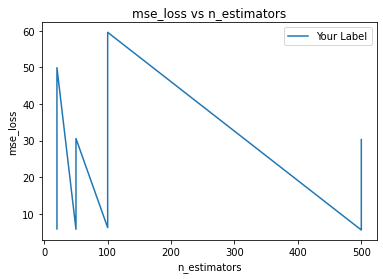

In [12]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_mse_loss

# Plotting the data
plt.plot(x_values, y_values, label='Your Label')

# Adding labels and title
plt.xlabel('n_estimators')
plt.ylabel('mse_loss')
plt.title('mse_loss vs n_estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

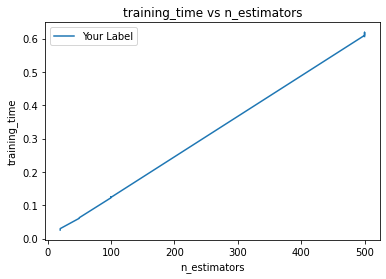

In [13]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_training_time

# Plotting the data
plt.plot(x_values, y_values, label='Your Label')

# Adding labels and title
plt.xlabel('n_estimators')
plt.ylabel('training_time')
plt.title('training_time vs n_estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

#### Best model : n_trees=500 , learning_rate=0.2 with mse_loss = 5.617 (Lowest)

In [45]:
## Testing on best model

gradboostModel = GradientBoostingReg(n_estimators=500,learning_rate=0.2,max_depth=5)
gradboostModel.fit(X_train_regression,y_train_regression)
y_pred = gradboostModel.predict(X_test_regression)
mse_loss = np.mean((y_test_regression-y_pred)**2)

print(f"mse_loss on best model regression is :",mse_loss)

mse_loss on best model regression is : 11.105272897885596


<br>

## Classification

### Data Processing

### Gradient Boosting Classifier

In [60]:
"""
Taken help of ChatGPT for this class
"""

class GradientBoostingCls:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Make the first prediction the log-odds of the class probabilities
        self.base_prediction = np.log(np.sum(y) / (len(y) - np.sum(y)))
        prediction = np.full_like(y, self.base_prediction)
        prediction = prediction.astype(np.float64)

        for _ in range(self.n_estimators):
            # Compute the negative gradient (log-odds of class probabilities)
            neg_gradient = y - 1 / (1 + np.exp(-prediction))
            # Fit a decision tree to the negative gradient
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, neg_gradient)
            # Make predictions with the current tree
            tree_prediction = tree.predict(X)
            # Update the overall prediction with a scaled version of the tree's prediction
            prediction += self.learning_rate * tree_prediction
            # Store the tree in the list of trees
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions using all the trees and scale by the learning rate
        predictions = np.array([self.learning_rate * tree.predict(X) for tree in self.trees]).sum(axis=0)
        # Add the initial prediction (log-odds of class probabilities)
        predictions += self.base_prediction
        # Convert log-odds to class probabilities
        probabilities = 1 / (1 + np.exp(-predictions))
        # Threshold probabilities to get class predictions (binary classification)
        class_predictions = (probabilities >= 0.5).astype(int)
        return class_predictions.astype(np.float64)


In [47]:
from prettytable import PrettyTable
import time

results = []

for num_trees in [20,50,100,500]:
        for learning_rate in [0.01,0.001,0.2]:
                    start_time = time.time()

                    gradboostModel = GradientBoostingCls(n_estimators=num_trees,learning_rate=learning_rate,max_depth=15)
                    gradboostModel.fit(X_train_classification,y_train_classification)
                    y_pred = gradboostModel.predict(X_val_classification)
                    accuracy = np.mean(y_pred==y_val_classification)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "learning_rate" : learning_rate,
                            "accuracy" : round(accuracy,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="accuracy", ascending=False).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees","learning_rate","accuracy","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"],row["learning_rate"],row["accuracy"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+---------------+----------+----------------------+
| n_trees | learning_rate | accuracy |    training_time     |
+---------+---------------+----------+----------------------+
|   50.0  |      0.01     |  0.708   | 0.15266728401184082  |
|  500.0  |      0.01     |  0.702   |  1.5437631607055664  |
|  100.0  |      0.2      |  0.702   |  0.3083806037902832  |
|   20.0  |      0.2      |  0.696   | 0.059969425201416016 |
|  500.0  |     0.001     |  0.696   |  1.6094882488250732  |
|  500.0  |      0.2      |   0.69   |  1.5801401138305664  |
|  100.0  |      0.01     |   0.69   |  0.311734676361084   |
|   50.0  |      0.2      |   0.69   | 0.15087676048278809  |
|   20.0  |      0.01     |   0.62   | 0.06941652297973633  |
|   20.0  |     0.001     |   0.62   | 0.07058286666870117  |
+---------+---------------+----------+----------------------+


In [14]:
# Given data
n_trees_values = [50.0, 500.0, 100.0, 20.0, 500.0, 500.0, 100.0, 50.0, 20.0, 20.0]
learning_rate_values = [0.01, 0.01, 0.2, 0.2, 0.001, 0.2, 0.01, 0.2, 0.01, 0.001]
accuracy_values = [0.708, 0.702, 0.702, 0.696, 0.696, 0.69, 0.69, 0.69, 0.62, 0.62]
training_time_values = [0.15266728401184082, 1.5437631607055664, 0.3083806037902832, 0.059969425201416016, 1.6094882488250732, 1.5801401138305664, 0.311734676361084, 0.15087676048278809, 0.06941652297973633, 0.07058286666870117]

# Sorting based on n_trees
sorted_indices = sorted(range(len(n_trees_values)), key=lambda k: n_trees_values[k])
sorted_n_trees = [n_trees_values[i] for i in sorted_indices]
sorted_learning_rate = [learning_rate_values[i] for i in sorted_indices]
sorted_accuracy = [accuracy_values[i] for i in sorted_indices]
sorted_training_time = [training_time_values[i] for i in sorted_indices]

# Display the sorted lists
print("Sorted n_trees:", sorted_n_trees)
print("Corresponding learning_rate:", sorted_learning_rate)
print("Corresponding accuracy:", sorted_accuracy)
print("Corresponding training_time:", sorted_training_time)

Sorted n_trees: [20.0, 20.0, 20.0, 50.0, 50.0, 100.0, 100.0, 500.0, 500.0, 500.0]
Corresponding learning_rate: [0.2, 0.01, 0.001, 0.01, 0.2, 0.2, 0.01, 0.01, 0.001, 0.2]
Corresponding accuracy: [0.696, 0.62, 0.62, 0.708, 0.69, 0.702, 0.69, 0.702, 0.696, 0.69]
Corresponding training_time: [0.059969425201416016, 0.06941652297973633, 0.07058286666870117, 0.15266728401184082, 0.15087676048278809, 0.3083806037902832, 0.311734676361084, 1.5437631607055664, 1.6094882488250732, 1.5801401138305664]


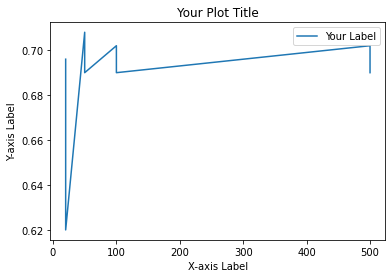

In [15]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_accuracy

# Plotting the data
plt.plot(x_values, y_values, label='Your Label')

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Your Plot Title')

# Adding legend
plt.legend()

# Display the plot
plt.show()

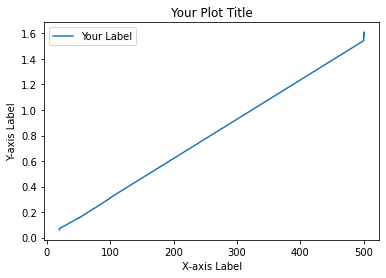

In [16]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_training_time

# Plotting the data
plt.plot(x_values, y_values, label='Your Label')

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Your Plot Title')

# Adding legend
plt.legend()

# Display the plot
plt.show()

#### Best model : n_trees=50 , learning_rate = 0.01 with accuracy = 70.8 % (Highest)

In [48]:
## Test best model on test data

gradboostModel = GradientBoostingCls(n_estimators=num_trees,learning_rate=learning_rate,max_depth=15)
gradboostModel.fit(X_train_classification,y_train_classification)
y_pred = gradboostModel.predict(X_test_classification)
accuracy = np.mean(y_pred==y_test_classification)

print(f"Accuracy of best model on test data classification : ",accuracy)

Accuracy of best model on test data classification :  0.6744186046511628


### Data Processing

# ADABOOST DECISION TREES

## Adaboost Classification Trees

In [49]:
from sklearn.tree import DecisionTreeClassifier 

class AdaBoostCls:
    def __init__(self,num_estimators=10,max_depth = 2):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
    
    def resample_from_distribution(self,distribution,dataset):
        X,y = dataset
        indices = np.linspace(0,X.shape[0]-1,X.shape[0]).astype(int)
        resampled_indices = np.random.choice(indices,len(X),p=distribution)
        return X[resampled_indices],y[resampled_indices]

    def fit(self,X,y):

        self.trees = []
        distribution = np.ones(y.shape[0]) / y.shape[0]
        # initialize weight distribution

        X_new,y_new = X,y

        # make it like that for better thresholding
        y_new[y_new==0]=-1

        for _ in range(self.num_estimators):
            
            # classifier
            model = DecisionTreeClassifier(max_depth=self.max_depth)
            X_new,y_new= self.resample_from_distribution(distribution,(X_new,y_new))
            model.fit(X_new,y_new)

            # test and update weights
            y_pred = model.predict(X_new)
            bool_arr = (y_pred==y_new)

            # print(bool_arr[:20])
            # print(np.sum(distribution))

            # error_function
            if np.sum(1-bool_arr)==0:
                break
            error_function = np.sum(distribution*(1-bool_arr))
            e_m = error_function
            alpha_m = np.log((1-e_m)/e_m)

            self.trees.append([model,alpha_m])

            # update weight coeffecients
            distribution = distribution*np.exp(alpha_m*(1-bool_arr))
            distribution /= np.sum(distribution)
    
    def predict(self,X):
        predict=np.zeros(X.shape[0])
        for model,alpha_m in self.trees:
            predict+=model.predict(X)*alpha_m
        
        predict[predict>=0]=1
        predict[predict<0]=0
        return predict


In [55]:
# Hyper parameter tuning

from prettytable import PrettyTable
import time

results = []

for num_trees in [20,30,40,50,60,70,80,100,500]:
                    start_time = time.time()

                    model = AdaBoostCls(num_estimators=num_trees)
                    model.fit(X_train_classification,y_train_classification)
                    y_pred = model.predict(X_val_classification)
                    y_pred = y_pred.astype(int)
                    accuracy = np.mean(y_pred.astype(int)==y_val_classification)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "accuracy" : round(accuracy,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="accuracy", ascending=False).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees","accuracy","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"],row["accuracy"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+----------+----------------------+
| n_trees | accuracy |    training_time     |
+---------+----------+----------------------+
|   40.0  |  0.655   | 0.017105817794799805 |
|   50.0  |   0.62   | 0.018508434295654297 |
|  100.0  |  0.567   | 0.017939090728759766 |
|   80.0  |  0.556   | 0.014925241470336914 |
|   20.0  |  0.532   | 0.01844644546508789  |
|  500.0  |   0.48   | 0.01704263687133789  |
|   60.0  |  0.474   | 0.019953250885009766 |
|   70.0  |  0.456   | 0.019801855087280273 |
|   30.0  |  0.392   |  0.0199282169342041  |
+---------+----------+----------------------+


In [56]:
## Testing the best model on test data

model = AdaBoostCls(num_estimators=num_trees)
model.fit(X_train_classification,y_train_classification)
y_pred = model.predict(X_val_classification)
y_pred = y_pred.astype(int)
accuracy = np.mean(y_pred.astype(int)==y_val_classification)

print(f"Accuracy for best model classification :",accuracy)

Accuracy for best model classification : 0.6198830409356725


In [7]:
# Given data
n_trees_values = [40.0, 50.0, 100.0, 80.0, 20.0, 500.0, 60.0, 70.0, 30.0]
accuracy_values = [0.655, 0.62, 0.567, 0.556, 0.532, 0.48, 0.474, 0.456, 0.392]
training_time_values = [0.017105817794799805, 0.018508434295654297, 0.017939090728759766, 0.014925241470336914, 0.01844644546508789, 0.01704263687133789, 0.019953250885009766, 0.019801855087280273, 0.0199282169342041]

# Sorting based on n_trees
sorted_indices = sorted(range(len(n_trees_values)), key=lambda k: n_trees_values[k])
sorted_n_trees = [n_trees_values[i] for i in sorted_indices]
sorted_accuracy = [accuracy_values[i] for i in sorted_indices]
sorted_training_time = [training_time_values[i] for i in sorted_indices]

# Display the sorted lists
print("Sorted n_trees:", sorted_n_trees)
print("Corresponding accuracy:", sorted_accuracy)
print("Corresponding training_time:", sorted_training_time)

Sorted n_trees: [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 100.0, 500.0]
Corresponding accuracy: [0.532, 0.392, 0.655, 0.62, 0.474, 0.456, 0.556, 0.567, 0.48]
Corresponding training_time: [0.01844644546508789, 0.0199282169342041, 0.017105817794799805, 0.018508434295654297, 0.019953250885009766, 0.019801855087280273, 0.014925241470336914, 0.017939090728759766, 0.01704263687133789]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


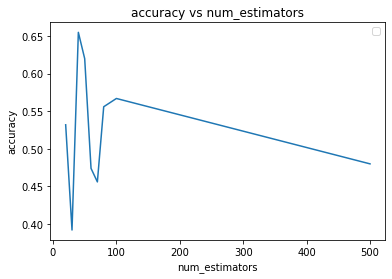

In [8]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_accuracy

# Plotting the data
plt.plot(x_values, y_values)

# Adding labels and title
plt.xlabel('num_estimators')
plt.ylabel('accuracy')
plt.title('accuracy vs num_estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


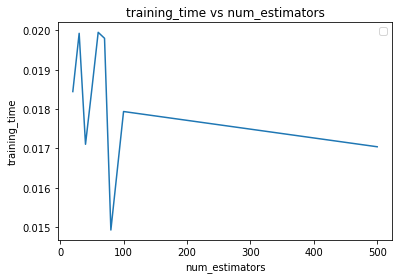

In [9]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_training_time

# Plotting the data
plt.plot(x_values, y_values)

# Adding labels and title
plt.xlabel('num_estimators')
plt.ylabel('training_time')
plt.title('training_time vs num_estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

##### Reason : It actually breaks when accuracy of a stump  becomes 100 % 

## Adaboost Regression Trees

In [18]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

"""
Taken help from blog and chatgpt
"""

class AdaBoostR2:
    def __init__(self, num_estimators=10, max_depth=1):
        self.num_estimators = num_estimators
        self.max_depth = max_depth
    
    def calculate_median_weighted(self, values, weights):
        sorted_indices = np.argsort(values)
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight_index = np.argmax(weights_cumulative_sum >= sum(weights) / 2)
        return values[median_weight_index]

    def sample_with_replacement(self):
        return np.random.choice(np.arange(self.N), size=self.N, replace=True, p=self.sample_weights)

    def train_single_estimator(self, X_train, y_train, sample_indices):
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(X_train[sample_indices], y_train[sample_indices])
        return tree.predict(X_train)

    def fit(self, X_train, y_train):
        self.y_train = y_train
        self.X_train = X_train

        self.N, self.D = X_train.shape
        self.sample_weights = np.repeat(1 / self.N, self.N)
        np.random.seed(42)

        self.estimators = []    
        self.predictions = np.empty((self.N, self.num_estimators))
        self.betas = []

        for t in range(self.num_estimators):
            # Sampling from the dataset with replacement
            sample_indices = self.sample_with_replacement()
            
            # Training a single estimator
            yhat = self.train_single_estimator(X_train, y_train, sample_indices)
            
            # Prediction on the training set
            self.estimators.append(yhat)
            self.predictions[:, t] = yhat
            
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t / D_t
            
            Lbar_t = np.sum(self.sample_weights * L_ts)
            
            if Lbar_t >= 0.5:
                self.num_estimators = t - 1
                self.predictions = self.predictions[:, :t - 1]
                self.estimators = self.estimators[:t - 1]
                break
            
            beta_t = Lbar_t / (1 - Lbar_t)
            self.betas.append(beta_t)
            
            Z_t = np.sum(self.sample_weights * beta_t ** (1 - L_ts))
            self.sample_weights *= beta_t ** (1 - L_ts) / Z_t
            
        self.model_weights = np.log(1 / np.array(self.betas))
        self.y_train_predicted = np.array([self.calculate_median_weighted(self.predictions[n], self.model_weights) for n in range(self.N)])
        
    def predict(self, X_test):
        N_test = len(X_test)
        test_predictions = np.empty((N_test, self.num_estimators))
        for t, yhat in enumerate(self.estimators):
            test_predictions[:, t] = yhat.predict(X_test)
        return np.array([self.calculate_median_weighted(test_predictions[n], self.model_weights) for n in range(N_test)])

### Testing Regression Adaboost Model

In [65]:
## Hyperparameter tuning


from prettytable import PrettyTable
import time

results = []

for num_trees in [1,2,3,4,5,10,20,30,40,50,60,70,100,500]:
                    start_time = time.time()

                    model = AdaBoostR2(num_estimators=num_trees)
                    model.fit(X_train_regression,y_train_regression)
                    y_pred = model.predict(X_val_regression)
                    mse_loss = np.mean((y_pred-y_val_regression)**2)

                    training_time = time.time() - start_time
                    
                    results.append({
                            "n_trees": num_trees,
                            "mse_loss" : round(mse_loss,3),
                            "training_time" : training_time
                })


# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by accuracy in descending order and select the top 10
top_10_accuracies = df.sort_values(by="mse_loss", ascending=True).head(10)

# Create a PrettyTable object
table = PrettyTable()

# Define your column names
column_names = ["n_trees","mse_loss","training_time"]

# Set the column names
table.field_names = column_names

# Iterate through the results and add rows
for index, row in top_10_accuracies.iterrows():
    table.add_row([row["n_trees"],row["mse_loss"],row["training_time"]])

# Print the table with borders and headers
print(table)

+---------+----------+-----------------------+
| n_trees | mse_loss |     training_time     |
+---------+----------+-----------------------+
|   5.0   |  25.475  | 0.0063130855560302734 |
|   4.0   |  25.863  |  0.006250143051147461 |
|   3.0   |  25.863  |  0.003926277160644531 |
|   2.0   |  30.228  | 0.0037305355072021484 |
|   1.0   |  30.228  |  0.004539966583251953 |
|   30.0  |  33.611  |  0.017393827438354492 |
|   50.0  |  33.611  |  0.016408920288085938 |
|   40.0  |  33.611  |  0.01608729362487793  |
|  100.0  |  33.611  |  0.015802383422851562 |
|  500.0  |  33.611  |  0.01602458953857422  |
+---------+----------+-----------------------+


In [4]:
# Given data
n_trees_values = [5.0, 4.0, 3.0, 2.0, 1.0, 30.0, 50.0, 40.0, 100.0, 500.0]
mse_loss_values = [25.475, 25.863, 25.863, 30.228, 30.228, 33.611, 33.611, 33.611, 33.611, 33.611]
training_time_values = [0.0063130855560302734, 0.006250143051147461, 0.003926277160644531, 0.0037305355072021484, 0.004539966583251953, 0.017393827438354492, 0.016408920288085938, 0.01608729362487793, 0.015802383422851562, 0.01602458953857422]

# Sorting based on n_trees
sorted_indices = sorted(range(len(n_trees_values)), key=lambda k: n_trees_values[k])
sorted_n_trees = [n_trees_values[i] for i in sorted_indices]
sorted_mse_loss = [mse_loss_values[i] for i in sorted_indices]
sorted_training_time = [training_time_values[i] for i in sorted_indices]

# Display the sorted lists
print("Sorted n_trees:", sorted_n_trees)
print("Corresponding mse_loss:", sorted_mse_loss)
print("Corresponding training_time:", sorted_training_time)

Sorted n_trees: [1.0, 2.0, 3.0, 4.0, 5.0, 30.0, 40.0, 50.0, 100.0, 500.0]
Corresponding mse_loss: [30.228, 30.228, 25.863, 25.863, 25.475, 33.611, 33.611, 33.611, 33.611, 33.611]
Corresponding training_time: [0.004539966583251953, 0.0037305355072021484, 0.003926277160644531, 0.006250143051147461, 0.0063130855560302734, 0.017393827438354492, 0.01608729362487793, 0.016408920288085938, 0.015802383422851562, 0.01602458953857422]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


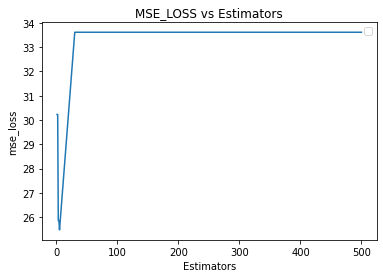

In [5]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_mse_loss

# Plotting the data
plt.plot(x_values, y_values)

# Adding labels and title
plt.xlabel('Estimators')
plt.ylabel('mse_loss')
plt.title('MSE_LOSS vs Estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


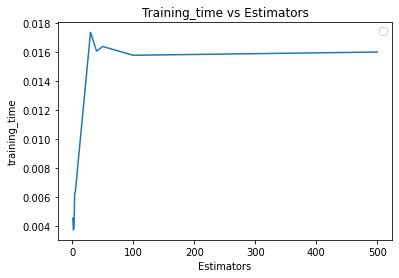

In [6]:
import matplotlib.pyplot as plt

# Example data
x_values = sorted_n_trees
y_values = sorted_training_time

# Plotting the data
plt.plot(x_values, y_values)

# Adding labels and title
plt.xlabel('Estimators')
plt.ylabel('training_time')
plt.title('Training_time vs Estimators')

# Adding legend
plt.legend()

# Display the plot
plt.show()

### Best model is n_trees = 5 with decision stumps and mse_loss : 25.475

In [66]:
## Testing on the best model

model = AdaBoostR2(num_estimators=5)
model.fit(X_train_regression,y_train_regression)
y_pred = model.predict(X_test_regression)
mse_loss = np.mean((y_pred-y_test_regression)**2)

print(f"mse_loss for the best model regression is (adaboost) : ",mse_loss)

mse_loss for the best model regression is (adaboost) :  49.33398246476862


## Analysis of the boosting models (AdaBoost & GradBoost)

# Analysis of Mistakes in Gradient Boosting + Decision Trees

## Common Mistakes:

1. **Overfitting:**
   - **Issue:** Gradient boosting can be prone to overfitting, especially if the base decision trees are deep.
   - **Explanation:** As each tree corrects the errors of the previous ones, if the trees are too complex, they can capture noise in the data, leading to overfitting.

2. **Sensitivity to Noisy Data:**
   - **Issue:** Gradient boosting can be sensitive to outliers and noisy data.
   - **Explanation:** Outliers can have a substantial impact on the model, and since boosting focuses on correcting errors, it might give too much weight to outliers.

3. **Computationally Intensive:**
   - **Issue:** Training a large number of decision trees can be computationally expensive.
   - **Explanation:** Gradient boosting involves sequentially adding trees to correct errors, and each tree is trained to minimize the residual errors. This sequential nature makes it more computationally intensive compared to parallel methods.

## Feature Similarity in Common Mistakes:

1. **Tree Structure:**
   - Both models rely on decision trees, and the structure of these trees can contribute to overfitting. If decision trees are allowed to grow too deep or are not pruned properly, they may capture noise instead of underlying patterns.

2. **Error Correction:**
   - Both models work by sequentially correcting errors made by the previous models. If the errors are noisy or if there's overfitting in the individual trees, this sequential correction might lead to an overly complex final model.

3. **Sensitivity to Outliers:**
   - Since both models aim to correct errors, they can be sensitive to outliers. Outliers may introduce noise that the models try to fit, leading to suboptimal generalization.

4. **Ensemble Nature:**
   - Both models are ensemble methods that combine weak learners to create a strong learner. While this can improve predictive performance, it also introduces complexities, such as potential overfitting and sensitivity to noisy data.

# Analysis of Mistakes in Adaboost + Decision Trees

## Common Mistakes:

1. **Overfitting:**
   - **Issue:** Adaboost can be susceptible to overfitting, especially if the base learners are too complex.
   - **Explanation:** Similar to gradient boosting, Adaboost focuses on correcting misclassifications by assigning higher weights to misclassified instances. If the base learners are too complex, they might overfit to the training data.

2. **Noisy Data Impact:**
   - **Issue:** Adaboost is sensitive to noisy data and outliers.
   - **Explanation:** As Adaboost gives more weight to misclassified instances, noisy data points or outliers can significantly influence the model's decision boundaries.

3. **Computational Complexity:**
   - **Issue:** Training multiple weak learners sequentially can be computationally expensive.
   - **Explanation:** Adaboost builds an ensemble by giving more weight to misclassified instances. This sequential process may be time-consuming, especially if the weak learners are computationally expensive.

## Feature Similarity in Common Mistakes:

1. **Weak Learners:**
   - Both models rely on decision trees as weak learners. If these trees are too complex or not properly constrained, they can contribute to overfitting.

2. **Error Correction:**
   - Both Adaboost and gradient boosting work by iteratively correcting errors made by the previous models. This sequential correction can be a source of overfitting if the base learners are too flexible.

3. **Sensitivity to Noisy Data:**
   - Both models are sensitive to noisy data and outliers. Since they focus on correcting errors, noisy data points may have a disproportionate influence on the final model.

4. **Ensemble Nature:**
   - Adaboost, like gradient boosting, is an ensemble method. The ensemble nature can lead to overfitting if not properly regularized or if weak learners are too complex.

### Overall Similarities:
Both models share similarities in terms of their reliance on decision trees, sequential error correction, and sensitivity to noisy data. Ensuring proper regularization of base learners, limiting tree depth, and considering the impact of outliers are crucial for mitigating these common mistakes in both gradient boosting and Adaboost with decision trees.

# END